<a href="https://colab.research.google.com/github/N00B-MA5TER/ML-Projects/blob/main/All_Classifier%2BRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


**Importing the Dependencies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_squared_error, r2_score
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, Ridge, Lasso, ElasticNet, LinearRegression, BayesianRidge
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    ExtraTreesClassifier, ExtraTreesRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    AdaBoostClassifier, AdaBoostRegressor,
    BaggingClassifier, BaggingRegressor,
    VotingClassifier, VotingRegressor,
    StackingClassifier, StackingRegressor
)
from sklearn.neural_network import MLPClassifier, MLPRegressor

# External libraries
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

**Importing the Adult Census Dataset**

In [ ]:
# Loading the dataset into a pandas dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv(url, names=cols, sep=", ", engine="python")

In [ ]:
# Creating a copy to implement the best possible model
df = data.copy()
dataset = data.copy()

In [ ]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
data.shape

(32561, 15)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Data Preprocessing**

Separating Features and Target

In [ ]:
# Encode target: <=50K -> 0, >50K -> 1
data["income"] = data["income"].map({"<=50K": 0, ">50K": 1})

In [ ]:
data["income"].value_counts()

,count
income,
0,24720
1,7841


In [ ]:
X = data.drop("income", axis=1)
y = data["income"]

In [ ]:
y.head()

,income
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Separate categorical and numerical features
cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(exclude="object").columns.tolist()

In [ ]:
# Creating separate Pipelines for Categorical and Numerical Features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_features)
    ]
)

**Defining Classifier and Regressor Models**

In [ ]:
# Classifier Models
classifiers = {
    "LogReg": LogisticRegression(max_iter=500),
    "RidgeClassifier": RidgeClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "NaiveBayes": GaussianNB(),
    "kNN_Classifier": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "MLP_Classifier": MLPClassifier(max_iter=500),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [ ]:
# Regressor Models
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "BayesianRidge": BayesianRidge(),
    "kNN_Regressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "MLP_Regressor": MLPRegressor(max_iter=500),
    "XGBRegressor": XGBRegressor(),
    "LightGBMRegressor": LGBMRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0)
}

**Function for Classification and Prediction**

In [ ]:
def benchmark_models(models, X, y, is_classifier=True):
    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) if is_classifier else StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

        # Cross-validated predictions
        y_pred = cross_val_predict(pipe, X, y, cv=kf, method="predict")

        # For classifiers, also get probabilities
        if is_classifier and hasattr(model, "predict_proba"):
            y_proba = cross_val_predict(pipe, X, y, cv=kf, method="predict_proba")[:,1]
        else:
            y_proba = y_pred

        # Metrics
        if is_classifier:
          acc = accuracy_score(y, y_pred)
          f1 = f1_score(y, y_pred)
          auc = roc_auc_score(y, y_proba)
          mse = mean_squared_error(y, y_proba)
          rmse = np.sqrt(mse)
          r2 = r2_score(y, y_proba)
        else:
          mse = mean_squared_error(y, y_pred)
          rmse = np.sqrt(mse)
          r2 = r2_score(y, y_pred)
          y_class = (y_pred >= 0.5).astype(int)
          acc = accuracy_score(y, y_class)
          f1 = f1_score(y, y_class)
          auc = roc_auc_score(y, y_pred)

        results.append([name, acc, f1, auc, mse, rmse, r2])

        # ✅ Print progress
        print(f"[{name}]  Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}, "
              f"MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

        # Visualization
        plt.figure(figsize=(5,5))
        plt.scatter(y, y_proba if is_classifier else y_pred, alpha=0.3, c='blue', label="Predicted")
        plt.plot([0,1],[0,1], color='red', linestyle='--', label="Ideal")  # diagonal reference
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Actual vs Predicted: {name}")
        plt.legend()
        plt.show()

        # Residual plot
        plt.figure(figsize=(5,5))
        residuals = (y - (y_proba if is_classifier else y_pred))
        plt.scatter(y, residuals, alpha=0.3, c='green')
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual")
        plt.ylabel("Residual (Actual - Predicted)")
        plt.title(f"Residual Plot: {name}")
        plt.show()

    cols = ["Model", "Accuracy", "F1", "AUC", "MSE", "RMSE", "R2"]
    return pd.DataFrame(results, columns=cols).sort_values(by="Accuracy", ascending=False)

**Model Training, Prediction and Plotting of Actual vs Predicted data**

Running Classifiers...
[LogReg]  Acc=0.8522, F1=0.6630, AUC=0.9067, MSE=0.1021, RMSE=0.3195, R2=0.4416


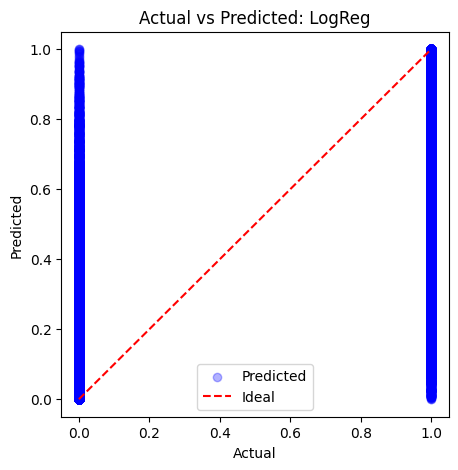

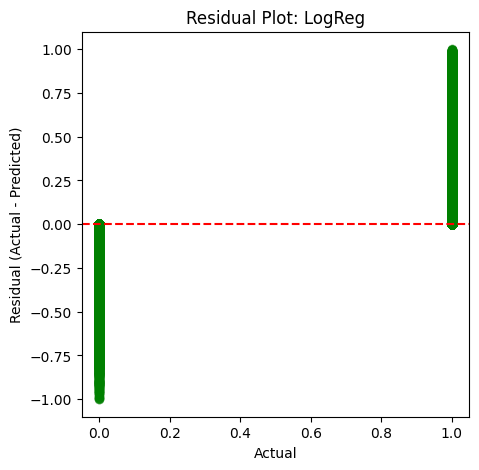

[RidgeClassifier]  Acc=0.8398, F1=0.6038, AUC=0.7261, MSE=0.1602, RMSE=0.4003, R2=0.1236


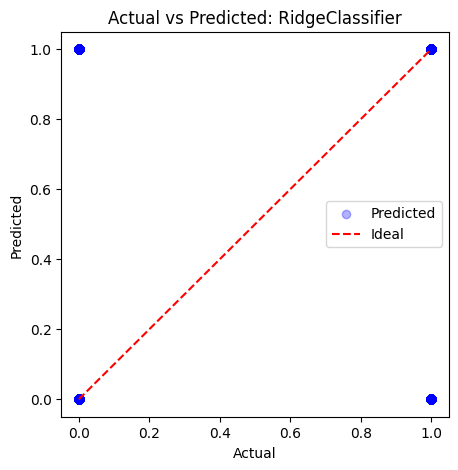

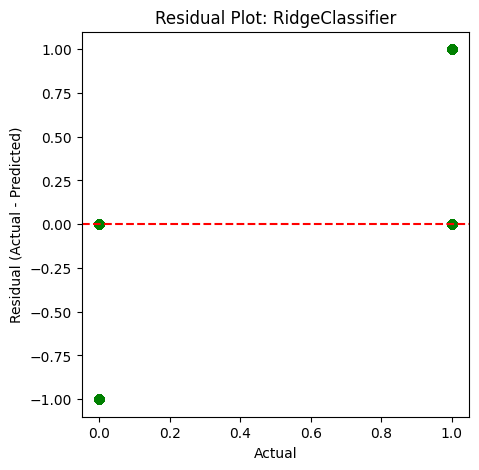

[LDA]  Acc=0.8412, F1=0.6316, AUC=0.8925, MSE=0.1099, RMSE=0.3315, R2=0.3988


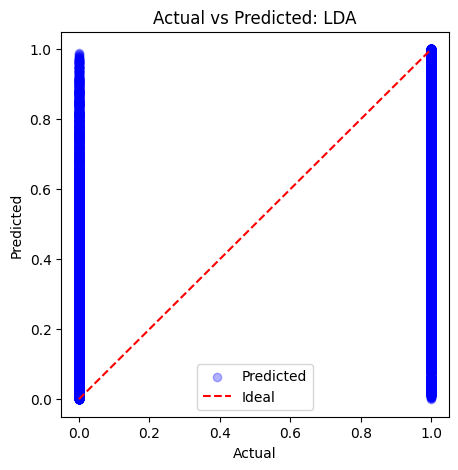

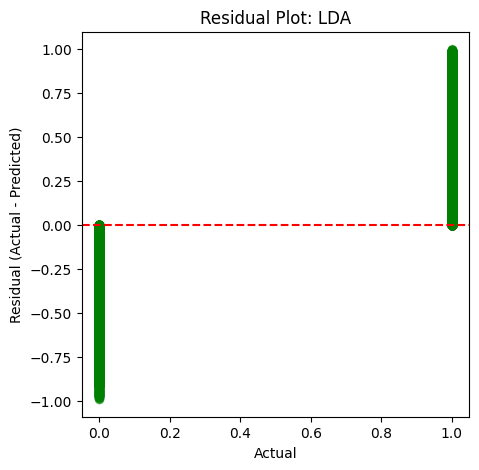

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

[QDA]  Acc=0.3613, F1=0.4238, AUC=0.5977, MSE=0.6373, RMSE=0.7983, R2=-2.4862


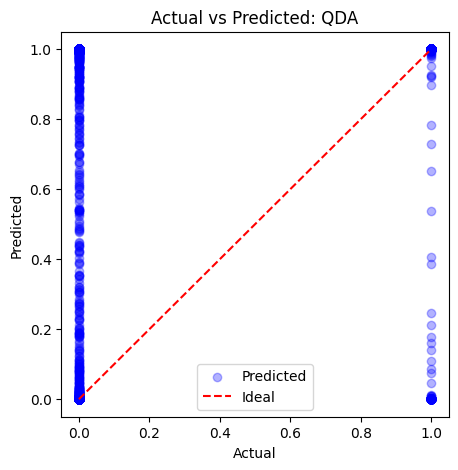

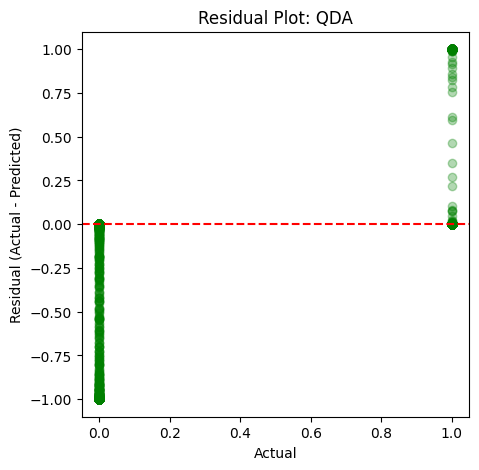

[NaiveBayes]  Acc=0.5460, F1=0.5020, AUC=0.7545, MSE=0.4501, RMSE=0.6709, R2=-1.4620


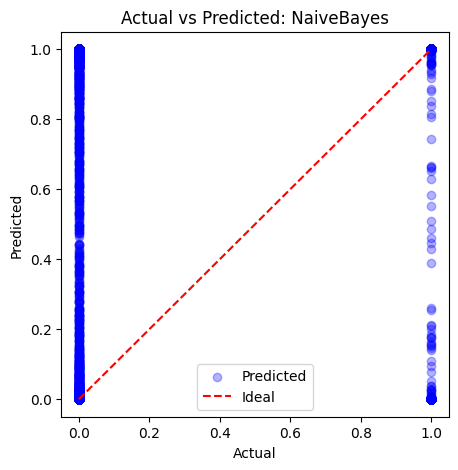

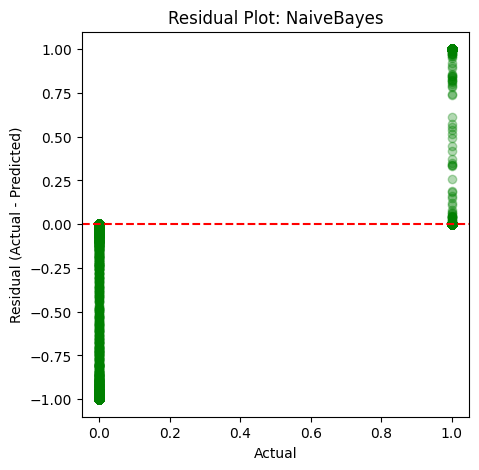

[kNN_Classifier]  Acc=0.8334, F1=0.6355, AUC=0.8614, MSE=0.1193, RMSE=0.3454, R2=0.3473


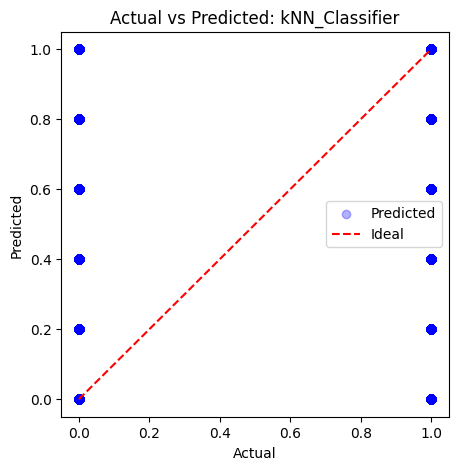

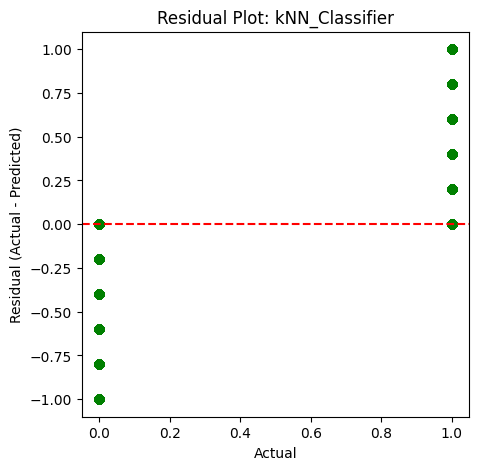

[SVM]  Acc=0.8565, F1=0.6638, AUC=0.9028, MSE=0.1050, RMSE=0.3240, R2=0.4257


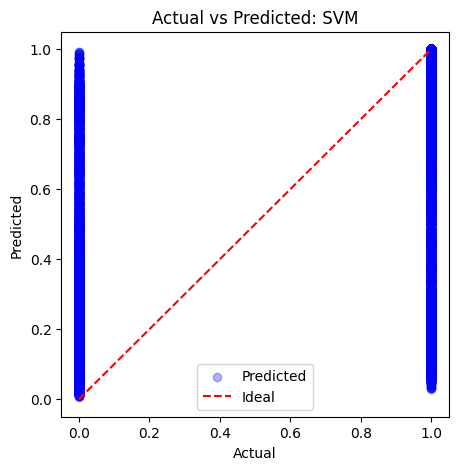

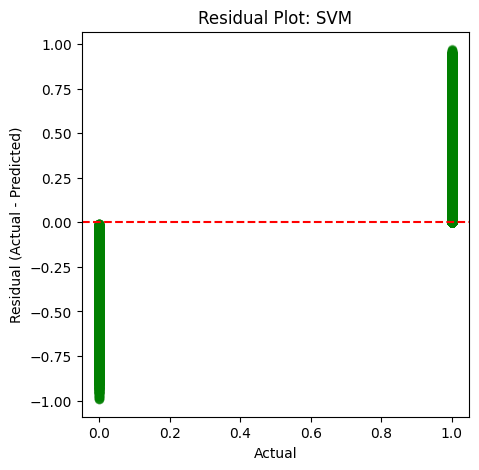

[DecisionTree]  Acc=0.8145, F1=0.6192, AUC=0.7489, MSE=0.1870, RMSE=0.4324, R2=-0.0226


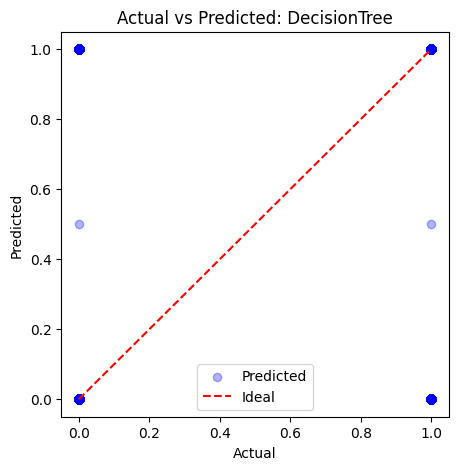

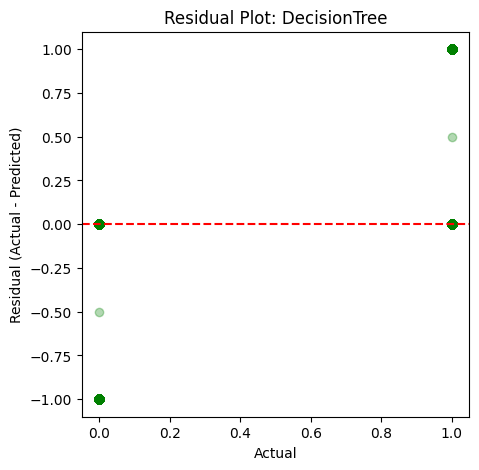

[ExtraTrees]  Acc=0.8342, F1=0.6359, AUC=0.8792, MSE=0.1175, RMSE=0.3428, R2=0.3573


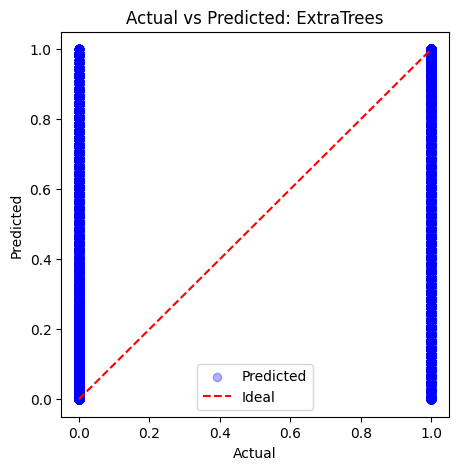

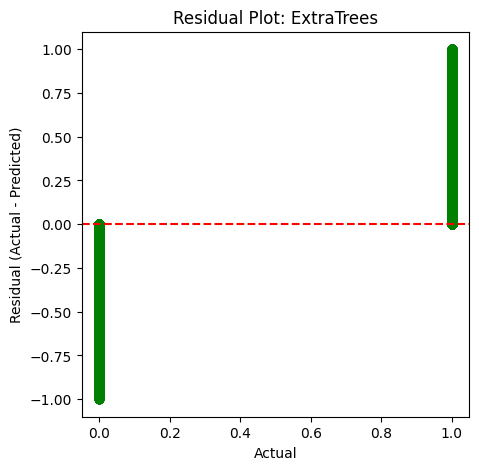

[RandomForest]  Acc=0.8551, F1=0.6747, AUC=0.9034, MSE=0.1023, RMSE=0.3198, R2=0.4406


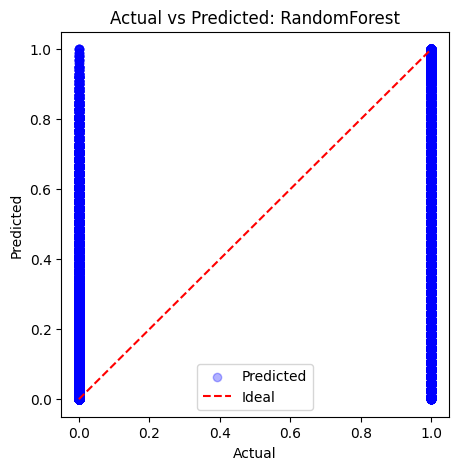

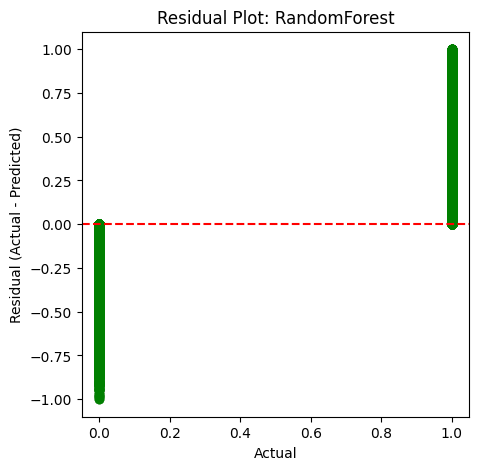

[GradientBoosting]  Acc=0.8653, F1=0.6828, AUC=0.9213, MSE=0.0925, RMSE=0.3041, R2=0.4941


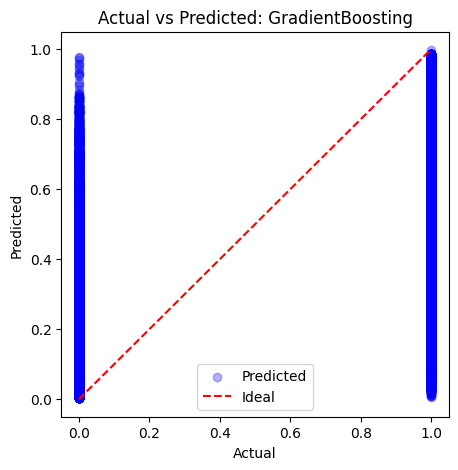

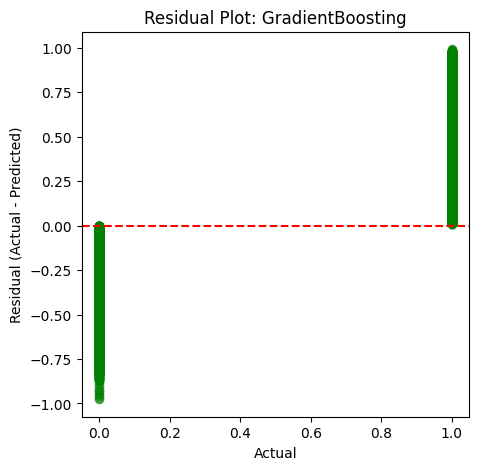

[AdaBoost]  Acc=0.8528, F1=0.6534, AUC=0.9048, MSE=0.1619, RMSE=0.4023, R2=0.1146


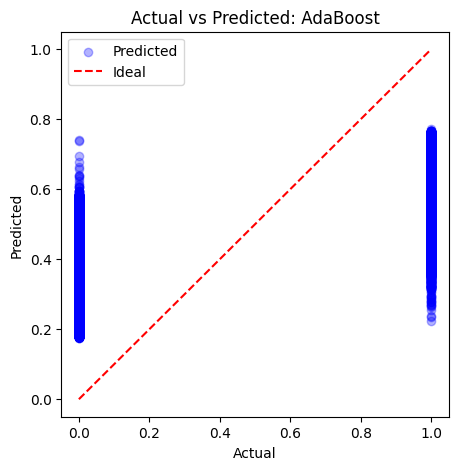

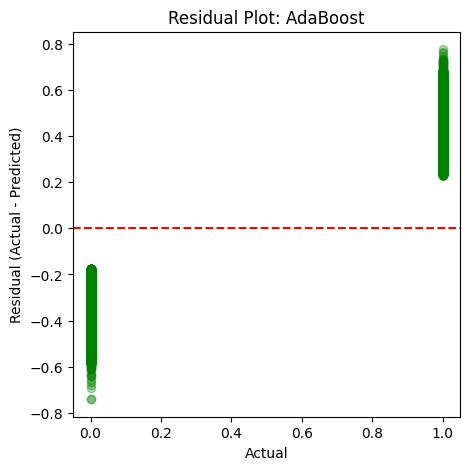

[MLP_Classifier]  Acc=0.8332, F1=0.6361, AUC=0.8834, MSE=0.1220, RMSE=0.3493, R2=0.3328


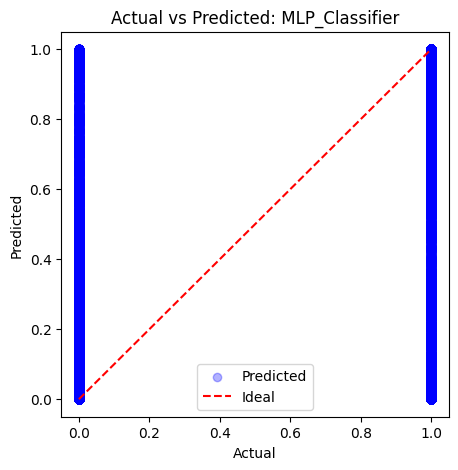

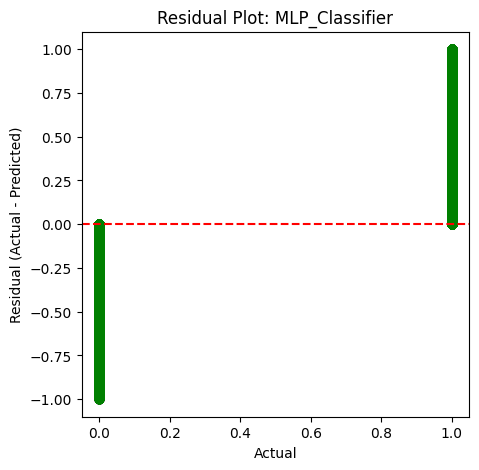

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:28:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:28:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:28:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:28:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:28:29] WARNING: /w

[XGBoost]  Acc=0.8711, F1=0.7115, AUC=0.9282, MSE=0.0888, RMSE=0.2979, R2=0.5145


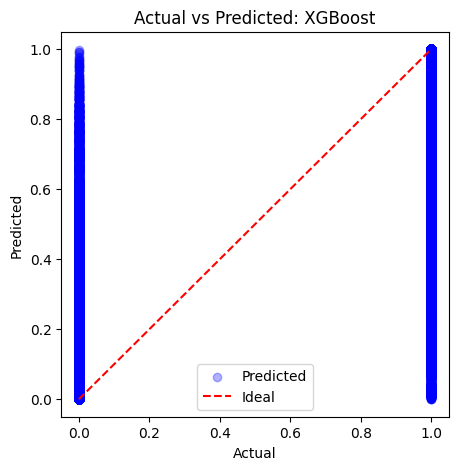

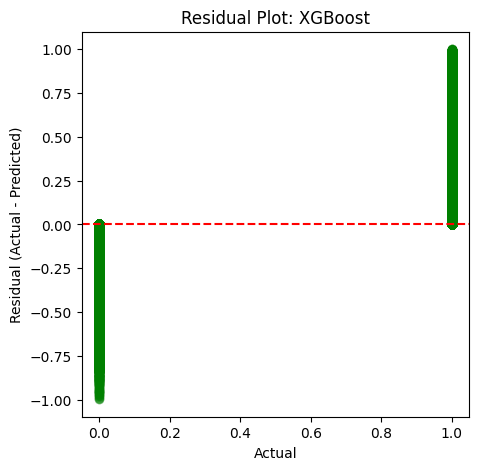

[LightGBM] [Info] Number of positive: 6272, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240786 -> initscore=-1.148374
[LightGBM] [Info] Start training from score -1.148374


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6272, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240786 -> initscore=-1.148374
[LightGBM] [Info] Start training from score -1.148374


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240815 -> initscore=-1.148214
[LightGBM] [Info] Start training from score -1.148214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM]  Acc=0.8738, F1=0.7161, AUC=0.9286, MSE=0.0880, RMSE=0.2966, R2=0.5188


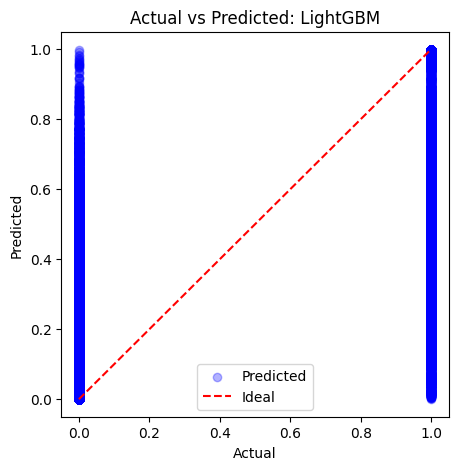

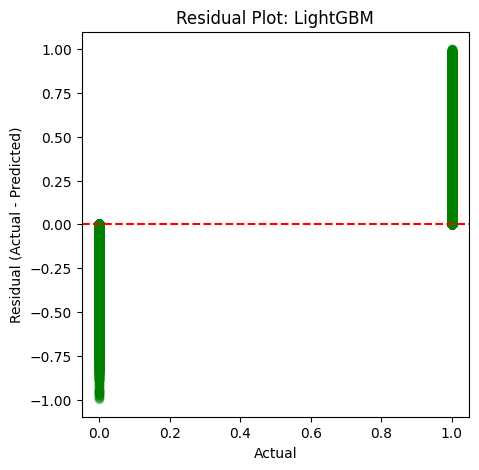

[CatBoost]  Acc=0.8750, F1=0.7172, AUC=0.9302, MSE=0.0873, RMSE=0.2954, R2=0.5227


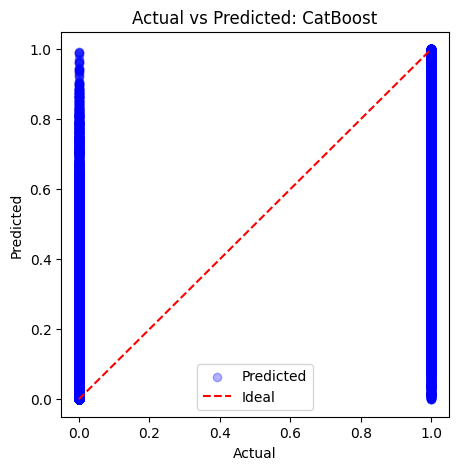

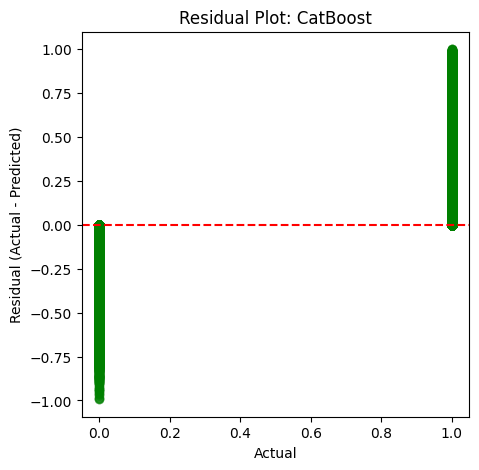

Running Regressors...
[LinearRegression]  Acc=0.8398, F1=0.6039, AUC=0.8925, MSE=0.1161, RMSE=0.3407, R2=0.3652


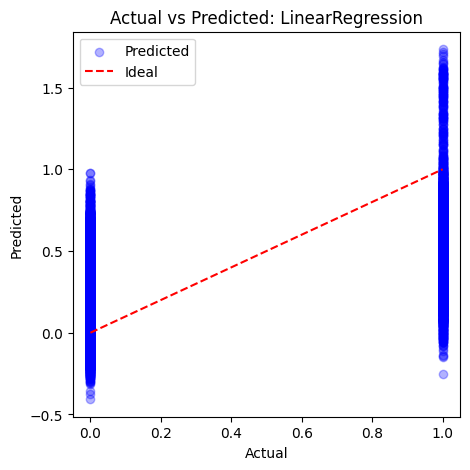

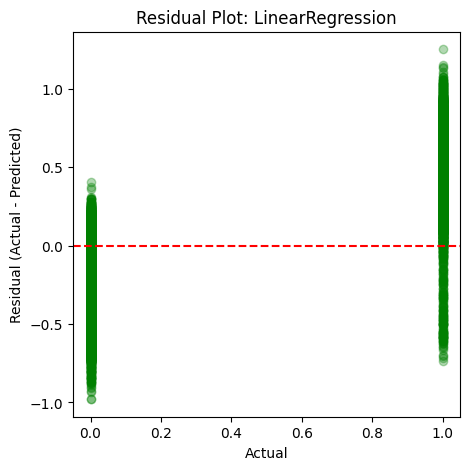

[Ridge]  Acc=0.8398, F1=0.6038, AUC=0.8925, MSE=0.1160, RMSE=0.3407, R2=0.3652


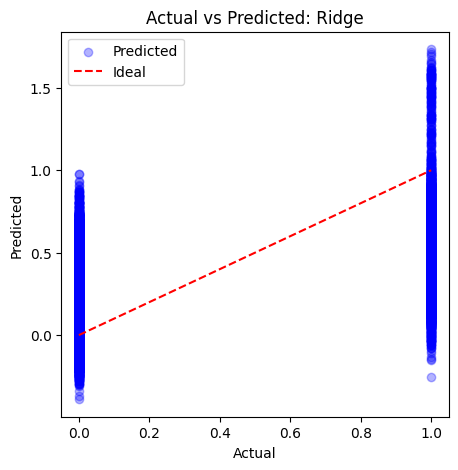

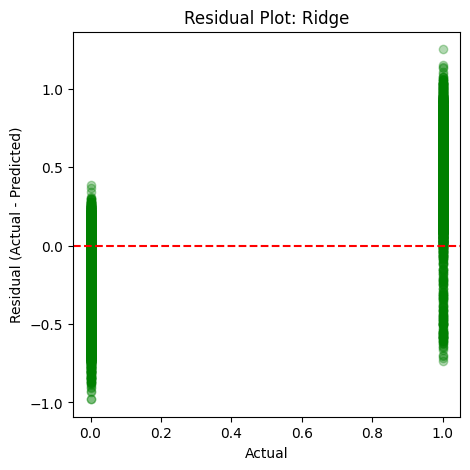

[Lasso]  Acc=0.7592, F1=0.0000, AUC=0.4999, MSE=0.1828, RMSE=0.4276, R2=-0.0000


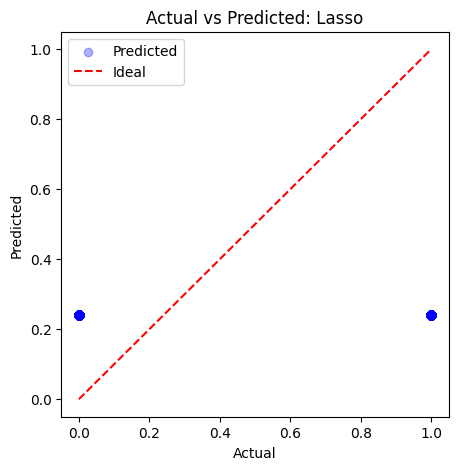

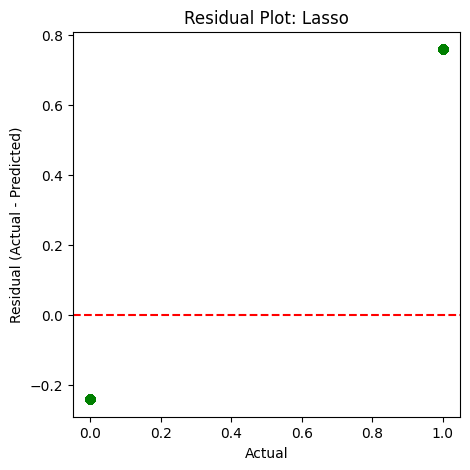

[ElasticNet]  Acc=0.7592, F1=0.0000, AUC=0.4999, MSE=0.1828, RMSE=0.4276, R2=-0.0000


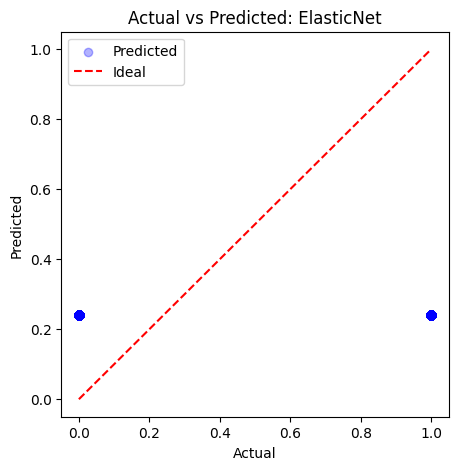

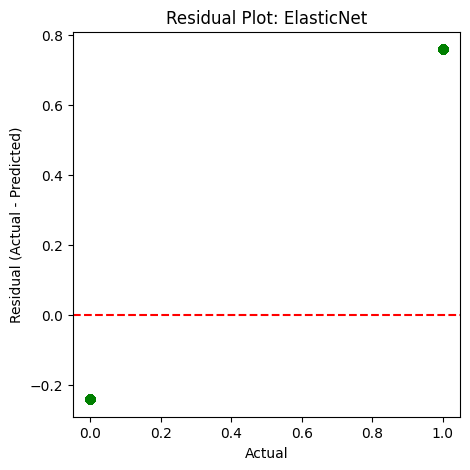

[BayesianRidge]  Acc=0.8397, F1=0.6022, AUC=0.8930, MSE=0.1159, RMSE=0.3405, R2=0.3659


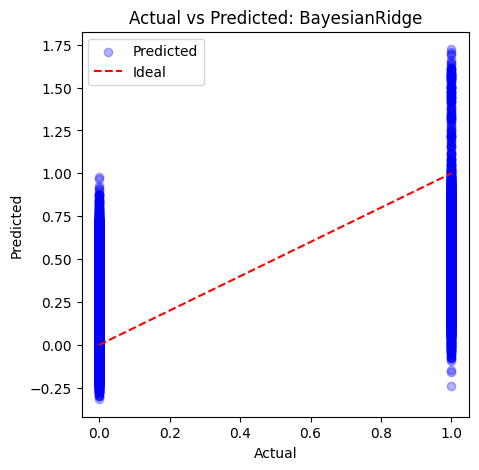

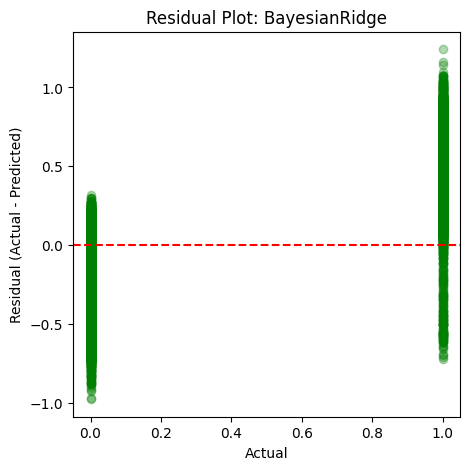

[kNN_Regressor]  Acc=0.8334, F1=0.6355, AUC=0.8614, MSE=0.1193, RMSE=0.3454, R2=0.3473


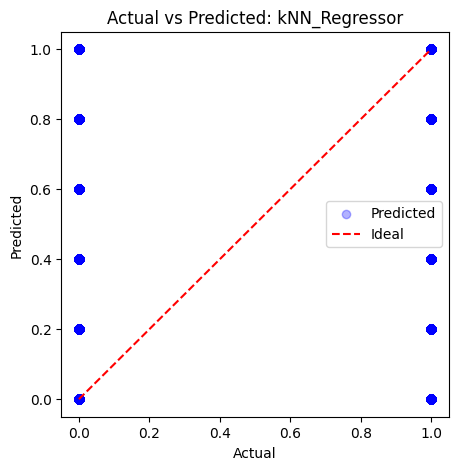

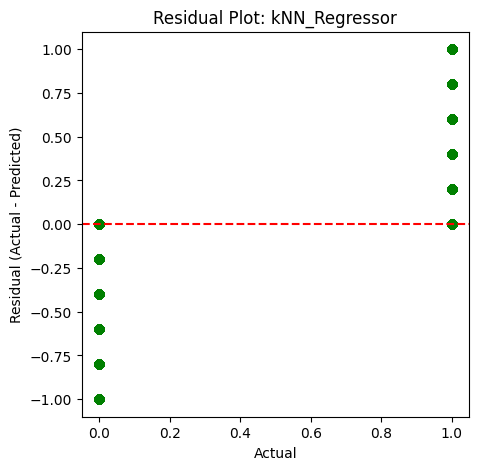

[SVR]  Acc=0.8569, F1=0.6689, AUC=0.8930, MSE=0.1084, RMSE=0.3293, R2=0.4070


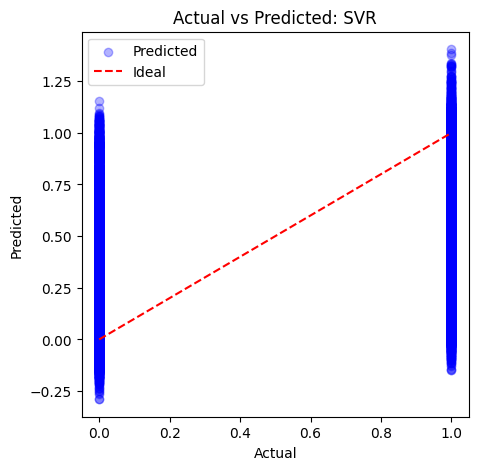

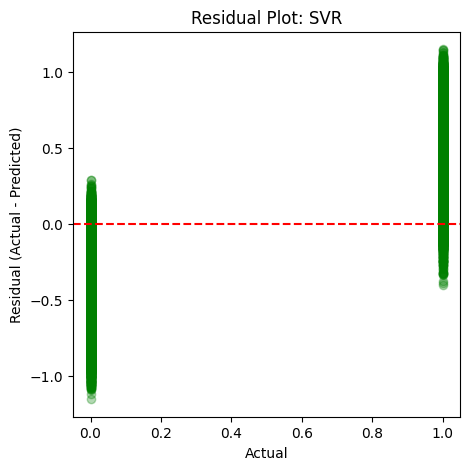

[DecisionTreeRegressor]  Acc=0.8151, F1=0.6210, AUC=0.7516, MSE=0.1848, RMSE=0.4299, R2=-0.0111


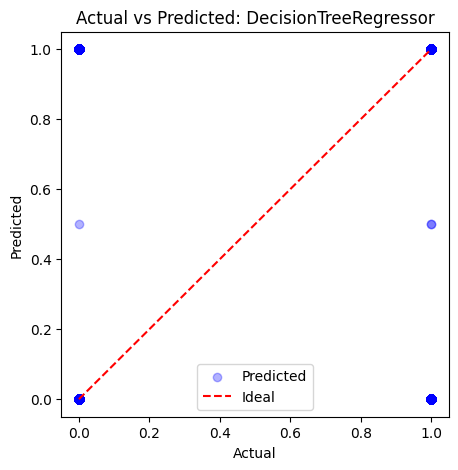

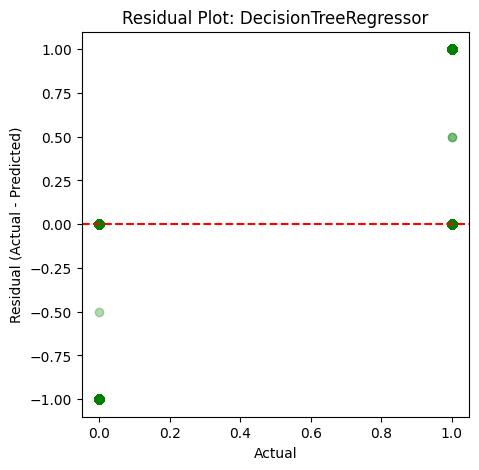

[ExtraTreesRegressor]  Acc=0.8399, F1=0.6582, AUC=0.8835, MSE=0.1150, RMSE=0.3392, R2=0.3708


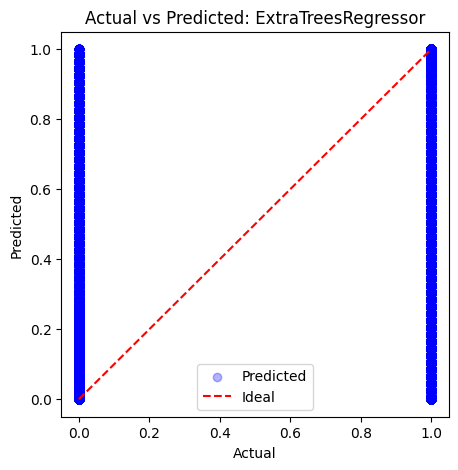

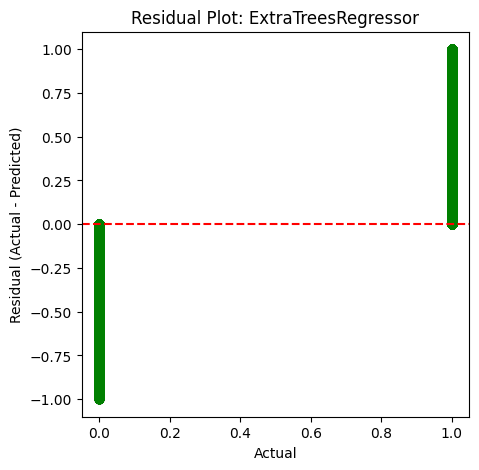

[RandomForestRegressor]  Acc=0.8565, F1=0.6809, AUC=0.9045, MSE=0.1009, RMSE=0.3176, R2=0.4481


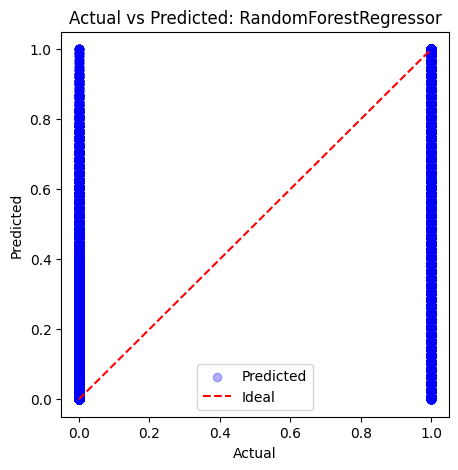

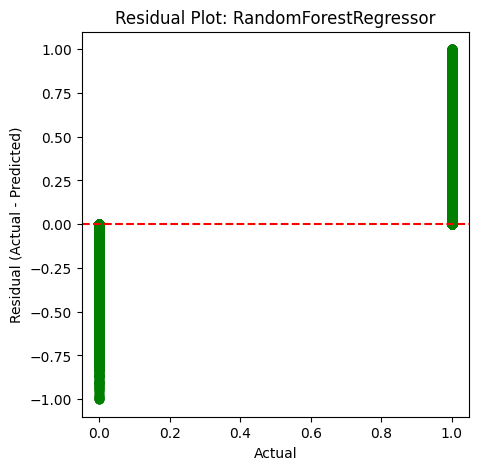

[GradientBoostingRegressor]  Acc=0.8631, F1=0.6693, AUC=0.9189, MSE=0.0948, RMSE=0.3079, R2=0.4816


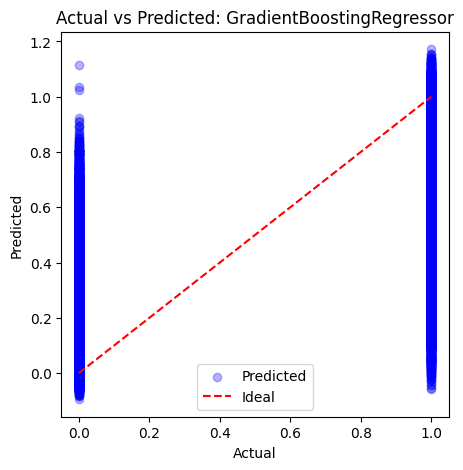

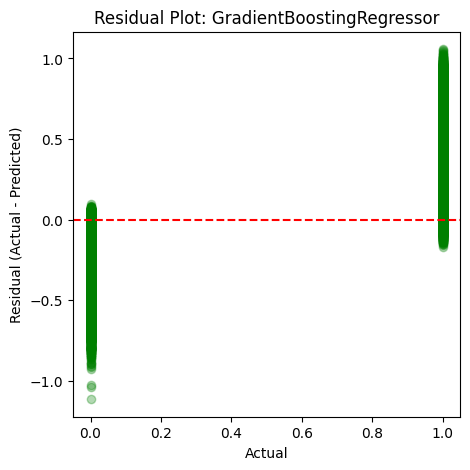

[AdaBoostRegressor]  Acc=0.8444, F1=0.6359, AUC=0.8958, MSE=0.1207, RMSE=0.3474, R2=0.3398


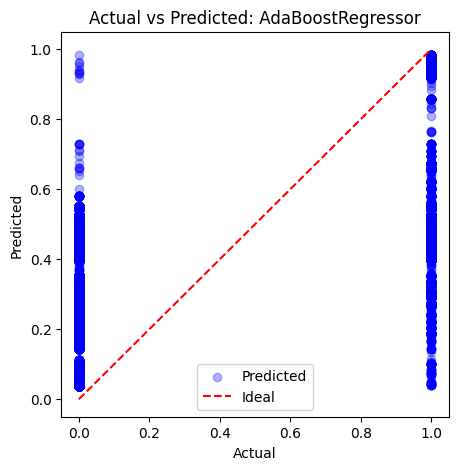

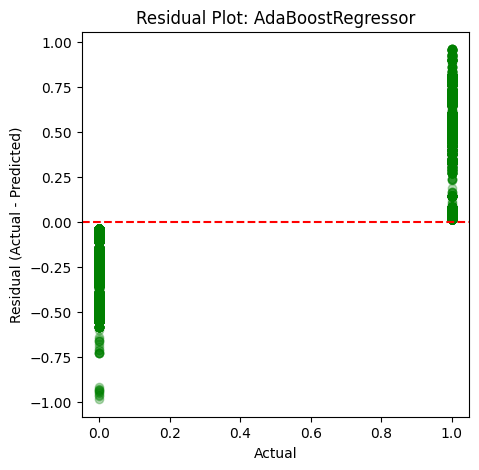

[MLP_Regressor]  Acc=0.8461, F1=0.6620, AUC=0.8840, MSE=0.1154, RMSE=0.3397, R2=0.3688


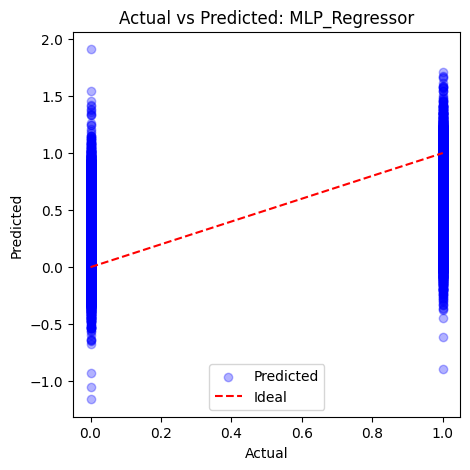

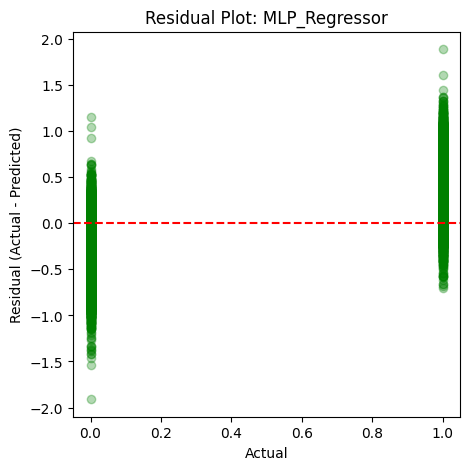

[XGBRegressor]  Acc=0.8710, F1=0.7072, AUC=0.9216, MSE=0.0913, RMSE=0.3022, R2=0.5005


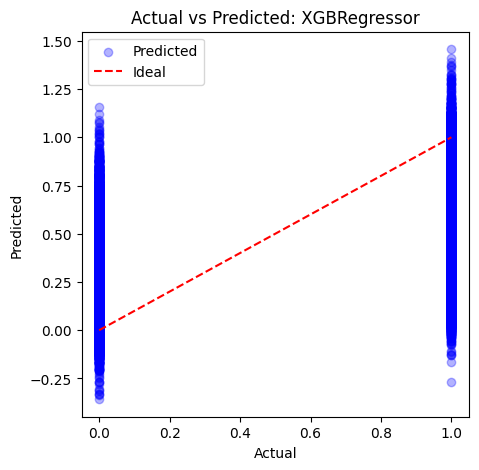

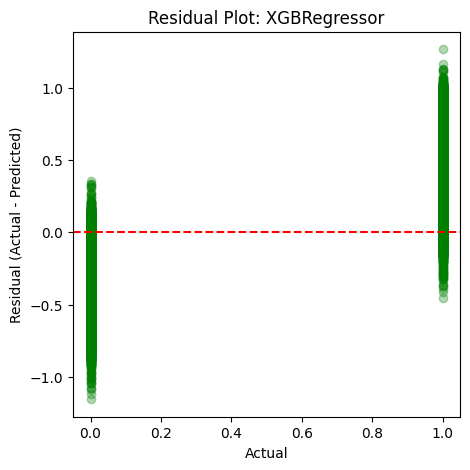

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 94
[LightGBM] [Info] Start training from score 0.240786


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 94
[LightGBM] [Info] Start training from score 0.240815


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] Start training from score 0.240815


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] Start training from score 0.240815


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 92
[LightGBM] [Info] Start training from score 0.240815


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBMRegressor]  Acc=0.8721, F1=0.7077, AUC=0.9262, MSE=0.0893, RMSE=0.2988, R2=0.5116


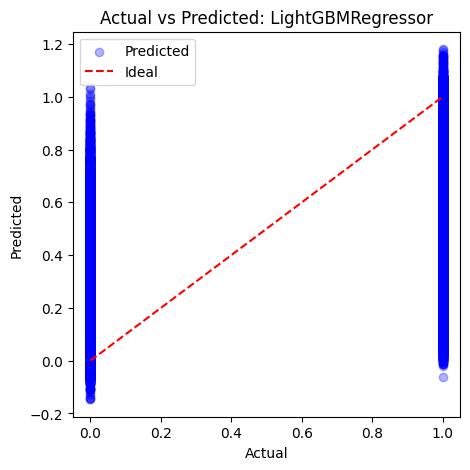

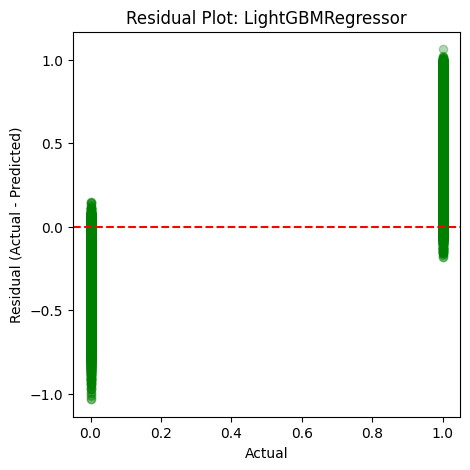

[CatBoostRegressor]  Acc=0.8741, F1=0.7101, AUC=0.9274, MSE=0.0888, RMSE=0.2980, R2=0.5143


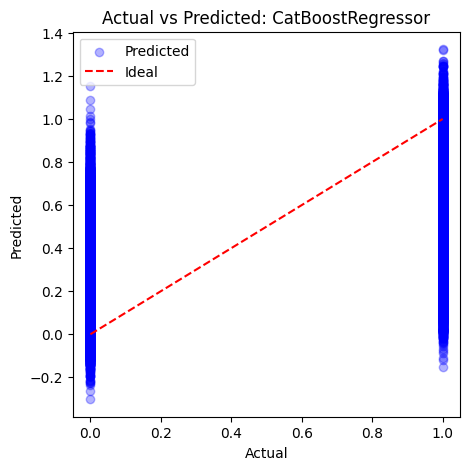

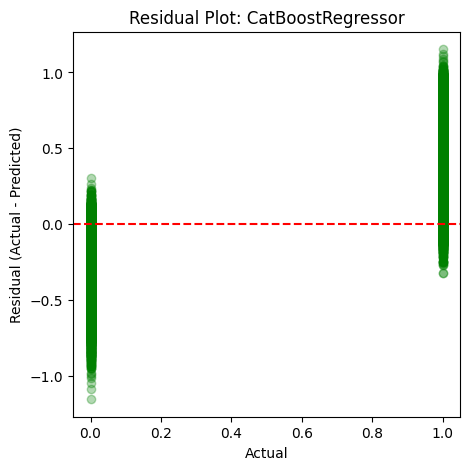

In [ ]:
print("Running Classifiers...")
clf_results = benchmark_models(classifiers, X, y, is_classifier=True)

print("Running Regressors...")
reg_results = benchmark_models(regressors, X, y, is_classifier=False)

**Classifier and Regressor Result Metrics**

In [ ]:
print("=== Classifier Results ===")
print(clf_results)

print("=== Regressor Results ===")
print(reg_results)

=== Classifier Results ===
               Model  Accuracy        F1       AUC       MSE      RMSE  \
15          CatBoost  0.875004  0.717204  0.930166  0.087255  0.295390   
14          LightGBM  0.873837  0.716063  0.928580  0.087980  0.296615   
13           XGBoost  0.871134  0.711536  0.928175  0.088757  0.297922   
10  GradientBoosting  0.865299  0.682817  0.921258  0.092494  0.304129   
6                SVM  0.856454  0.663838  0.902821  0.104999  0.324035   
9       RandomForest  0.855103  0.674710  0.903358  0.102278  0.319809   
11          AdaBoost  0.852799  0.653359  0.904832  0.161867  0.402326   
0             LogReg  0.852247  0.662977  0.906746  0.102084  0.319505   
2                LDA  0.841190  0.631616  0.892476  0.109919  0.331540   
1    RidgeClassifier  0.839778  0.603782  0.726149  0.160222  0.400278   
8         ExtraTrees  0.834157  0.635873  0.879176  0.117506  0.342791   
5     kNN_Classifier  0.833390  0.635490  0.861425  0.119324  0.345434   
12    MLP_C

**Using Best Possible Model**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import clone
rng = np.random.RandomState(42)

Preprocessing

In [ ]:
df["income"]

,income
0,0
1,0
2,0
3,0
4,0
...,...
32556,0
32557,1
32558,0
32559,0


In [ ]:
# Features and target
X = df.drop("income", axis=1)
y = df["income"]

In [ ]:
# Encode categorical features
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [ ]:
# Separate feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [ ]:
# ColumnTransformer: Numerical + Categorical Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_features)
    ]
)

**Splitting the dataset into Training data and Test data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Defining Base Models**

In [ ]:
catboost = CatBoostClassifier(
    iterations=300, learning_rate=0.1, depth=8, verbose=0, random_state=42
)

lightgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=-1, random_state=42
)

xgboost = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=8, eval_metric="logloss", random_state=42, use_label_encoder=False
)

**Hybrid Model (Final Estimator)**

In [ ]:
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack = StackingClassifier(
    estimators=[
        ("catboost", catboost),
        ("lightgbm", lightgbm),
        ("xgboost", xgboost)
    ],
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True  # Pass original features + predictions to meta-model
)

**Full Pipeline (Preprocessing + Model)**

In [ ]:
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("stack", stack)
])

**Training the model**

In [ ]:
print("🔄 Training the Stacking Model...")
clf.fit(X_train, y_train)

🔄 Training the Stacking Model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder'...
                                                               learning_rate=0.05,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=8,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=500,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1, passthrough=True))])

**Evaluation**

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("\n=== Model Performance ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC:  {auc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Model Performance ===
Accuracy: 0.8795
F1 Score: 0.7305
ROC-AUC:  0.8109

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.79      0.68      0.73      1568

    accuracy                           0.88      6513
   macro avg       0.85      0.81      0.83      6513
weighted avg       0.88      0.88      0.88      6513



**Confusion Matrix**

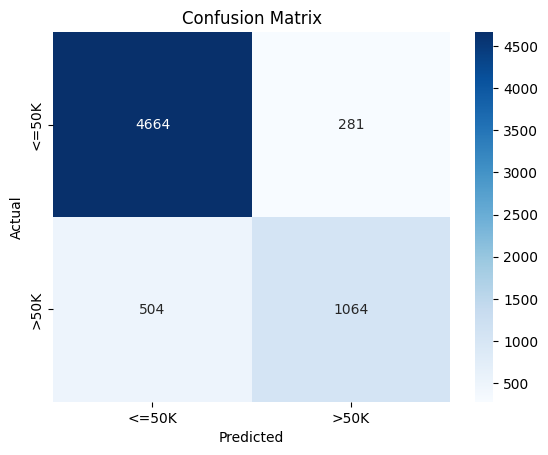

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(32561, 14) (26048, 14) (6513, 14)


**Plot Actual vs Predicted Probabilities**

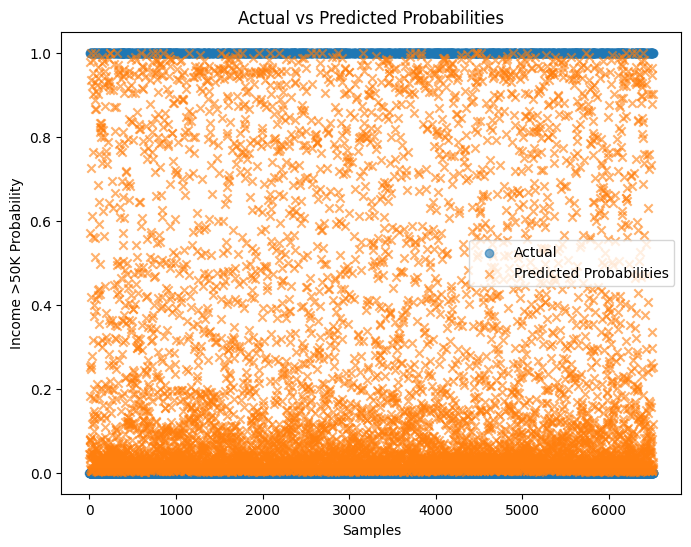

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, alpha=0.6, label="Actual", marker="o")
plt.scatter(range(len(y_pred_proba)), y_pred_proba, alpha=0.6, label="Predicted Probabilities", marker="x")
plt.legend()
plt.title("Actual vs Predicted Probabilities")
plt.xlabel("Samples")
plt.ylabel("Income >50K Probability")
plt.show()

### **Stacking + Optuna Tuning (Last try!)**

**Preprocess**

In [ ]:
X = dataset.drop("income", axis=1)
y = (dataset["income"] == ">50K").astype(int)  # binary target

In [ ]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

**Train-Test-Split**

In [ ]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ]
)

In [ ]:
# Fit preprocessor on train, transform both
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

In [ ]:
print(f"Train shape after OHE: {X_train.shape}, Test shape: {X_test.shape}, Pos rate: {y.mean():.3f}")

Train shape after OHE: (26048, 14), Test shape: (6513, 14), Pos rate: 0.000


**Optuna Optimization**

In [ ]:
def make_models(trial):
    # class imbalance helper (Adult pos rate ~0.24; feel free to estimate from y_train)
    pos_rate = float(y_train.mean())
    spw = trial.suggest_float("xgb_scale_pos_weight", 0.5, max(1.0, (1 - pos_rate) / max(1e-6, pos_rate)))

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        base_score=0.5,              # 🔒 avoid base_score=0 issue
        n_estimators=trial.suggest_int("xgb_n_estimators", 200, 600),
        max_depth=trial.suggest_int("xgb_max_depth", 3, 10),
        learning_rate=trial.suggest_float("xgb_lr", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("xgb_colsample", 0.6, 1.0),
        min_child_weight=trial.suggest_float("xgb_min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("xgb_reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("xgb_reg_alpha", 0.0, 2.0),
        scale_pos_weight=spw,
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )

    lgbm = LGBMClassifier(
        objective="binary",
        n_estimators=trial.suggest_int("lgbm_n_estimators", 200, 600),
        max_depth=trial.suggest_int("lgbm_max_depth", 3, 10),
        learning_rate=trial.suggest_float("lgbm_lr", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("lgbm_subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("lgbm_colsample", 0.6, 1.0),
        num_leaves=trial.suggest_int("lgbm_num_leaves", 31, 255),
        min_child_samples=trial.suggest_int("lgbm_min_child_samples", 10, 100),
        reg_lambda=trial.suggest_float("lgbm_reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("lgbm_reg_alpha", 0.0, 2.0),
        n_jobs=-1,
        random_state=42
    )

    cat = CatBoostClassifier(
        loss_function="Logloss",
        iterations=trial.suggest_int("cat_iters", 200, 600),
        depth=trial.suggest_int("cat_depth", 3, 10),
        learning_rate=trial.suggest_float("cat_lr", 0.01, 0.3, log=True),
        l2_leaf_reg=trial.suggest_float("cat_l2", 1.0, 10.0),
        random_state=42,
        verbose=False
    )

    return xgb, lgbm, cat

In [ ]:
def objective(trial):
    xgb, lgbm, cat = make_models(trial)

    stack = StackingClassifier(
        estimators=[("xgb", xgb), ("lgbm", lgbm), ("cat", cat)],
        final_estimator=LogisticRegression(max_iter=500, n_jobs=-1, random_state=42),
        passthrough=True,
        n_jobs=-1,
        cv=3   # internal CV for meta-learner
    )

    # 3-fold outer CV for the trial to be robust (kept small for speed)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    accs = []

    try:
        for tr_idx, va_idx in skf.split(X_train, y_train):
            X_tr, X_va = X_train[tr_idx], X_train[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            stack.fit(X_tr, y_tr)
            preds = stack.predict(X_va)
            accs.append(accuracy_score(y_va, preds))

        score = float(np.mean(accs))
        print(f"Trial {trial.number} | Acc: {score:.4f}")
        return score

    except Exception as e:
        # If any base learner blows up (e.g., GPU/ABI oddities), skip the trial cleanly
        print(f"Trial {trial.number} failed with: {e}")
        return 0.0

**Running Optuna**

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n=== Best Trial Params ===")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")
print(f"Best CV Accuracy: {study.best_value:.4f}")

[I 2025-08-24 17:54:08,673] A new study created in memory with name: no-name-970c57c9-d9c9-4c06-8cad-34e711f892c6


  0%|          | 0/30 [00:00<?, ?it/s]

Trial 0 failed with: catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value
[I 2025-08-24 17:54:15,249] Trial 0 finished with value: 0.0 and parameters: {'xgb_scale_pos_weight': 830273.0085960437, 'xgb_n_estimators': 398, 'xgb_max_depth': 3, 'xgb_lr': 0.040125063674541384, 'xgb_subsample': 0.7458898433856735, 'xgb_colsample': 0.9669175916585941, 'xgb_min_child_weight': 4.810064264491788, 'xgb_reg_lambda': 0.571692946288696, 'xgb_reg_alpha': 1.895328720819461, 'lgbm_n_estimators': 491, 'lgbm_max_depth': 9, 'lgbm_lr': 0.014210087257211379, 'lgbm_subsample': 0.6656374553918672, 'lgbm_colsample': 0.8071686086219619, 'lgbm_num_leaves': 243, 'lgbm_min_child_samples': 56, 'lgbm_reg_lambda': 3.840754535482269, 'lgbm_reg_alpha': 0.37273225440179925, 'cat_iters': 391, 'cat_depth': 9, 'cat_lr': 0.026124281354066983, 'cat_l2': 7.4739165729582355}. Best is trial 0 with value: 0.0.
Trial 1 failed with: catboost/private/libs/target/target_converter.cpp:404: Targe

**Final Training with Best Params**

In [ ]:
best = study.best_trial.params
# Rebuild models with best params (and the same safe objectives)
best_xgb = XGBClassifier(
    **study_xgb.best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

lgbm_best = LGBMClassifier(
    objective="binary",
    n_estimators=best["lgbm_n_estimators"],
    max_depth=best["lgbm_max_depth"],
    learning_rate=best["lgbm_lr"],
    subsample=best["lgbm_subsample"],
    colsample_bytree=best["lgbm_colsample"],
    num_leaves=best["lgbm_num_leaves"],
    min_child_samples=best["lgbm_min_child_samples"],
    reg_lambda=best["lgbm_reg_lambda"],
    reg_alpha=best["lgbm_reg_alpha"],
    n_jobs=-1,
    random_state=42
)

cat_best = CatBoostClassifier(
    loss_function="Logloss",
    iterations=best["cat_iters"],
    depth=best["cat_depth"],
    learning_rate=best["cat_lr"],
    l2_leaf_reg=best["cat_l2"],
    random_state=42,
    verbose=False
)

stack_best = StackingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('lgbm', lgbm_best),
        ('cat', cat_best.set_params(class_weights=[1, 3]))  # ✅ add class weights to handle imbalance
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # ✅ ensures class balance
    stack_method="predict_proba",
    n_jobs=-1,
)

NameError: name 'study_xgb' is not defined

**Train the best stack**

In [ ]:
stack_best.fit(X_train, y_train)

CatBoostError: catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value